In [1]:
#import libraries.
import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import keras
from keras import regularizers
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import sounddevice as sd
import tensorflow as tf
from mir_eval import separation 
from pystoi.stoi import stoi 
import h5py
from keras.callbacks import LearningRateScheduler
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
import math
from sklearn.utils import shuffle
from sklearn import preprocessing
import soundfile as sf
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
#import libraries.
# import matplotlib.pyplot as plt
# from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
import time
import pickle
from keras import backend as K
from tensorflow.keras.models import load_model
# from keras.models import load_model

In [4]:
def reconstruct(wave,angle):
    recon1 = wave*np.cos(angle)+wave*np.sin(angle)*1j
#     recon = np.sqrt(np.power(10, wave))
#     recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=160, win_length=400, window='hann')
    return recon

# Loading Model

In [60]:
estimator_A = load_model('Models/Two_stage/512_2/saved-model-adam-049-0.0515.hdf5')
name0 = '512_2_49_SDR'
name1 = '512_2_49_STOI'

In [40]:
data_series = str(2)

In [7]:
h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_mixed_FFT'  + data_series + '.hdf5','r')
data_shape = h5f['Test_TSP_mixed_FFT' + data_series].shape
print(data_shape)
h5f.close()

(257, 23227)


# Data 

In [8]:
# all
test_point_start0 = 0
test_point_stop0 = data_shape[1]

In [9]:
# FM
FM_test_point_start0 =  0
FM_test_point_stop0 = int(data_shape[1]/3) - 155

In [10]:
# FF
FF_test_point_start0 =  int(data_shape[1]/3) - 155
FF_test_point_stop0 = int(2 * data_shape[1]/3) - 110

In [11]:
# MM
MM_test_point_start0 =  int(2 * data_shape[1]/3) - 110
MM_test_point_stop0 = data_shape[1]

In [12]:
indx = [test_point_start0, test_point_stop0, FM_test_point_start0, FM_test_point_stop0, FF_test_point_start0, 
        FF_test_point_stop0, MM_test_point_start0, MM_test_point_stop0]

In [13]:
fft_samples = 257
sr = 16000

In [61]:
all_sdr = {}
all_stoi = {}
for i in range(0,len(indx),2):
    test_point_start0 = indx[i]
    test_point_stop0 = indx[i+1]
    h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_mixed_FFT'  + data_series + '.hdf5','r')
    test_input = h5f['Test_TSP_mixed_FFT' + data_series][:, test_point_start0 : test_point_stop0]
    h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_clean_FFTs'  + data_series + '.hdf5','r')
    test_target = h5f['Test_TSP_clean_FFTs' + data_series][:, test_point_start0 : test_point_stop0]
    h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_mixed_phase'  + data_series + '.hdf5','r')
    mixed_phase = h5f['Test_TSP_mixed_phase' + data_series][:, test_point_start0 : test_point_stop0]
    h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_clean_phases'  + data_series + '.hdf5','r')
    clean_phase = h5f['Test_TSP_clean_phases' + data_series][:, test_point_start0 : test_point_stop0]
    norms = np.zeros(test_input.shape[1])
    for j in range(test_input.shape[1]):
        norms[j] = np.linalg.norm(test_input[:,j])
    test_input = preprocessing.normalize(test_input, norm='l2', axis=0, copy=True)
    prediction = estimator_A.predict(test_input.T)
    test_input = np.multiply(test_input,norms)
    prediction0 = np.multiply(test_input.T, prediction[:,0:fft_samples])
    prediction1 = np.multiply(test_input.T, prediction[:,fft_samples:])
    speaker1 = reconstruct(prediction0, mixed_phase.T)
    speaker2 = reconstruct(prediction1, mixed_phase.T)
    clean_recon1 = reconstruct(test_target[0:fft_samples,:].T, clean_phase[0:fft_samples,:].T)
    clean_recon2 = reconstruct(test_target[fft_samples:,:].T, clean_phase[fft_samples:,:].T)
    mixed_recon = reconstruct(test_input.T, mixed_phase.T)
    
    st_recon1 = stoi(speaker1, clean_recon1, sr, extended=False)
    st_recon2 = stoi(speaker2, clean_recon2, sr, extended=False)
    st_mixed1 = stoi(mixed_recon, clean_recon1, sr, extended=False)
    st_mixed2 = stoi(mixed_recon, clean_recon2, sr, extended=False)
    
    sdr_recon1, sir_recon1, sar_recon1, perm_recon1 = separation.bss_eval_sources(speaker1, clean_recon1, compute_permutation=True)
    sdr_recon2, sir_recon2, sar_recon2, perm_recon2 = separation.bss_eval_sources(speaker2, clean_recon2, compute_permutation=True)
    sdr_mixed1, sir_mixed1, sar_mixed1, perm_mixed1 = separation.bss_eval_sources(mixed_recon, clean_recon1, compute_permutation=True)
    sdr_mixed2, sir_mixed2, sar_mixed2, perm_mixed2 = separation.bss_eval_sources(mixed_recon, clean_recon2, compute_permutation=True)
    
    temp_sdr = [sdr_mixed1, sdr_recon1, sdr_mixed2, sdr_recon2]
    temp_stoi = [st_mixed1, st_recon1,  st_mixed2, st_recon2]
    
    all_sdr[str(i/2)] = temp_sdr
    all_stoi[str(i/2)] = temp_stoi

In [62]:
all_sdr

{'0.0': [array([1.06752682]),
  array([5.25555459]),
  array([0.16465937]),
  array([4.56953874])],
 '1.0': [array([5.04796643]),
  array([7.35863308]),
  array([-3.53653487]),
  array([0.98320472])],
 '2.0': [array([-0.38916225]),
  array([4.34409999]),
  array([2.37947836]),
  array([6.33674819])],
 '3.0': [array([0.63867618]),
  array([3.42785664]),
  array([0.14120552]),
  array([2.89713212])]}

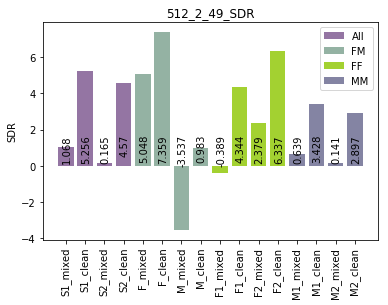

In [63]:

barWidth = 2

bars0 = ('S1_mixed','S1_clean', 'S2_mixed', 'S2_clean')
bars1 = ('F_mixed','F_clean', 'M_mixed', 'M_clean')
bars2 = ('F1_mixed','F1_clean', 'F2_mixed', 'F2_clean')
bars3 = ('M1_mixed','M1_clean', 'M2_mixed', 'M2_clean')

x_pos0 = np.arange(len(bars0)) + barWidth
x_pos1 = np.arange(len(bars1)) + len(bars0) + barWidth
x_pos2 = np.arange(len(bars2)) + len(bars0) + len(bars1) + barWidth
x_pos3 = np.arange(len(bars3)) + len(bars0) + len(bars1) + len(bars2) + barWidth
x_pos = list(x_pos0) + list(x_pos1) + list(x_pos2) + list(x_pos3)

 
# Create bars
plt.bar(x_pos0, np.squeeze(all_sdr['0.0']),color = (0.3,0.1,0.4,0.6), label='All')
plt.bar(x_pos1, np.squeeze(all_sdr['1.0']),color = (0.3,0.5,0.4,0.6), label='FM')
plt.bar(x_pos2, np.squeeze(all_sdr['2.0']),color = (0.6,0.8,0.1,0.9), label='FF')
plt.bar(x_pos3, np.squeeze(all_sdr['3.0']),color = (0.2,0.2,0.4,0.6), label='MM')

# Create legend
plt.legend()

# write the values
values =  list(np.round(np.squeeze(all_sdr['0.0']),3)) + list(np.round(np.squeeze(all_sdr['1.0']),3)) + list(np.round(np.squeeze(all_sdr['2.0']),3)) + list(np.round(np.squeeze(all_sdr['3.0']),3))
for i, v in enumerate(values):
    plt.text(i + barWidth - 0.2, 1.3 , str(v), color='black', fontsize=10, rotation=90)

# lables
plt.title(name0)
# ax.t_xlabel()
plt.ylabel('SDR')
# Create names on the x-axis
plt.xticks([r + barWidth for r in range(len(x_pos))], 
           ['S1_mixed','S1_clean', 'S2_mixed', 'S2_clean',
            'F_mixed','F_clean', 'M_mixed', 'M_clean',
            'F1_mixed','F1_clean', 'F2_mixed', 'F2_clean',
            'M1_mixed','M1_clean', 'M2_mixed', 'M2_clean'
            ], rotation=90)
fig1 = plt.gcf()
plt.show()
fig1.savefig('figures/' + name0 + '.png', dpi=300 , bbox_inches='tight')



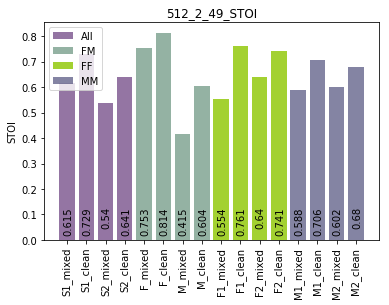

In [64]:

barWidth = 2

bars0 = ('S1_mixed','S1_clean', 'S2_mixed', 'S2_clean')
bars1 = ('F_mixed','F_clean', 'M_mixed', 'M_clean')
bars2 = ('F1_mixed','F1_clean', 'F2_mixed', 'F2_clean')
bars3 = ('M1_mixed','M1_clean', 'M2_mixed', 'M2_clean')

x_pos0 = np.arange(len(bars0)) + barWidth
x_pos1 = np.arange(len(bars1)) + len(bars0) + barWidth
x_pos2 = np.arange(len(bars2)) + len(bars0) + len(bars1) + barWidth
x_pos3 = np.arange(len(bars3)) + len(bars0) + len(bars1) + len(bars2) + barWidth
x_pos = list(x_pos0) + list(x_pos1) + list(x_pos2) + list(x_pos3)

 
# Create bars
plt.bar(x_pos0, np.squeeze(all_stoi['0.0']),color = (0.3,0.1,0.4,0.6), label='All')
plt.bar(x_pos1, np.squeeze(all_stoi['1.0']),color = (0.3,0.5,0.4,0.6), label='FM')
plt.bar(x_pos2, np.squeeze(all_stoi['2.0']),color = (0.6,0.8,0.1,0.9), label='FF')
plt.bar(x_pos3, np.squeeze(all_stoi['3.0']),color = (0.2,0.2,0.4,0.6), label='MM')

# Create legend
plt.legend()

# write the values
values =  list(np.round(np.squeeze(all_stoi['0.0']),3)) + list(np.round(np.squeeze(all_stoi['1.0']),3)) + list(np.round(np.squeeze(all_stoi['2.0']),3)) + list(np.round(np.squeeze(all_stoi['3.0']),3))
for i, v in enumerate(values):
    plt.text(i + barWidth - 0.2, 0.1 , str(v), color='black', fontsize=10, rotation=90)

# lables
plt.title(name1)
# ax.t_xlabel()
plt.ylabel('STOI')
# Create names on the x-axis
plt.xticks([r + barWidth for r in range(len(x_pos))], 
           ['S1_mixed','S1_clean', 'S2_mixed', 'S2_clean',
            'F_mixed','F_clean', 'M_mixed', 'M_clean',
            'F1_mixed','F1_clean', 'F2_mixed', 'F2_clean',
            'M1_mixed','M1_clean', 'M2_mixed', 'M2_clean'
            ], rotation=90)
fig2 = plt.gcf()
plt.show()
fig2.savefig('figures/' + name1 + '.png', dpi=300 , bbox_inches='tight')



In [25]:
print('STOI_recon1=', st_recon1)
print('STOI_recon2=', st_recon2)
print('STOI_mixed1=', st_mixed1)
print('STOI_mixed2=', st_mixed2)

STOI_recon1= 0.7484800260927625
STOI_recon2= 0.6617332535895908
STOI_mixed1= 0.6283168544837595
STOI_mixed2= 0.5435481313152923


In [26]:
sdr_recon1, sir_recon1, sar_recon1, perm_recon1 = separation.bss_eval_sources(speaker1, clean_recon1, compute_permutation=True)
sdr_recon2, sir_recon2, sar_recon2, perm_recon2 = separation.bss_eval_sources(speaker2, clean_recon2, compute_permutation=True)

In [27]:
sdr_mixed1, sir_mixed1, sar_mixed1, perm_mixed1 = separation.bss_eval_sources(mixed_recon, clean_recon1, compute_permutation=True)
sdr_mixed2, sir_mixed2, sar_mixed2, perm_mixed2 = separation.bss_eval_sources(mixed_recon, clean_recon2, compute_permutation=True)

In [28]:
print('SDR_recon1=', sdr_recon1)
print('SDR_recon2=', sdr_recon2)
print('SDR_mixed1=', sdr_mixed1)
print('SDR_mixed2=', sdr_mixed2)

SDR_recon1= [5.61239878]
SDR_recon2= [4.72275549]
SDR_mixed1= [1.36286961]
SDR_mixed2= [-0.16238854]


In [249]:
print('SIR_recon1=', sir_recon1)
print('SIR_recon2=', sir_recon2)
print('SIR_mixed1=', sir_mixed1)
print('SIR_mixed2=', sir_mixed2)

SIR_recon1= [inf]
SIR_recon2= [inf]
SIR_mixed1= [inf]
SIR_mixed2= [inf]


In [50]:
sd.play(speaker1[0:125632], sr)

In [55]:
sd.play(speaker2[0:125632], sr)

In [227]:
sd.play(clean_recon1[0:125632], sr)

In [56]:
sd.play(clean_recon2[0:125632], sr)

In [54]:
sd.play(mixed_recon[0:125632], sr)

In [51]:
mixed_recon.shape

(1256320,)

In [376]:
sf.write('TSP/Predicted/speaker1_FM.wav', speaker1, 48000)
sf.write('TSP/Predicted/speaker2_FM.wav', speaker2, 48000)
sf.write('TSP/Predicted/clean1_FM.wav', clean_recon1, 48000)
sf.write('TSP/Predicted/clean2_FM.wav', clean_recon2, 48000)
sf.write('TSP/Predicted/mixed_FM.wav', mixed_recon, 48000)

In [397]:
sf.write('TSP/Predicted/speaker1_FF.wav', speaker1, 48000)
sf.write('TSP/Predicted/speaker2_FF.wav', speaker2, 48000)
sf.write('TSP/Predicted/clean1_FF.wav', clean_recon1, 48000)
sf.write('TSP/Predicted/clean2_FF.wav', clean_recon2, 48000)
sf.write('TSP/Predicted/mixed_FF.wav', mixed_recon, 48000)

In [413]:
sf.write('TSP/Predicted/speaker1_MM.wav', speaker1, 48000)
sf.write('TSP/Predicted/speaker2_MM.wav', speaker2, 48000)
sf.write('TSP/Predicted/clean1_MM.wav', clean_recon1, 48000)
sf.write('TSP/Predicted/clean2_MM.wav', clean_recon2, 48000)
sf.write('TSP/Predicted/mixed_MM.wav', mixed_recon, 48000)

In [30]:
from pypesq import pesq
score = pesq(clean_recon1, speaker1, 48000)
print(score)

ValueError: sample rate must be 16000 or 8000

In [98]:
def loss_DNNC(y_true = test_target.T, y_pred = test_target.T, Lambda = 0.05):
    loss = K.sum(K.square(y_true - y_pred)) 
    - Lambda * K.sum(K.square(y_true[0:257,:] - y_pred[0:257,:]) + K.square(y_true[257:,:] - y_pred[257:,:]))
    return loss

In [99]:
estimator_C = load_model('Models/Two_stage/Model_C0.h5', 
                          custom_objects={'loss_DNNC': loss_DNNC})

In [100]:
sec_set = np.concatenate((speaker1 , speaker2), axis=1)

In [101]:
sec_set = preprocessing.normalize(sec_set, norm='l2', axis=1, copy=True)
test_target = preprocessing.normalize(test_target, norm='l2', axis=1, copy=True)

In [102]:
prediction2 = estimator_C.predict(sec_set)

In [103]:
prediction2.shape

(18634, 514)

In [104]:
s1_C = reconstruct(prediction2[:,0:257], angle_mixed)
s2_C = reconstruct(prediction2[:,257:], angle_mixed)

In [105]:
clean_recon1 = reconstruct(test_target[:,0:fft_samples], angle_clean[:,0:fft_samples])
clean_recon2 = reconstruct(test_target[:,fft_samples:], angle_clean[:,fft_samples:])

In [106]:
st_recon1 = stoi(s1_C, clean_recon1, 16000, extended=False)
st_recon2 = stoi(s2_C, clean_recon2, 16000, extended=False)

In [107]:
sdr_recon1, sir_recon1, sar_recon1, perm_recon1 = separation.bss_eval_sources(s1_C, clean_recon1, compute_permutation=True)
sdr_recon2, sir_recon2, sar_recon2, perm_recon2 = separation.bss_eval_sources(s2_C, clean_recon2, compute_permutation=True)

In [108]:
print('SDR_recon1=', sdr_recon1)
print('SDR_recon2=', sdr_recon2)
print('SDR_mixed=', sdr_mixed)

SDR_recon1= [-4.51841408]
SDR_recon2= [-2.20552222]
SDR_mixed= [-4.78920035]


In [109]:
print('STOI_recon1=', st_recon1)
print('STOI_recon2=', st_recon2)
print('STOI_mixed=', st_mixed)

STOI_recon1= 0.2992286684160478
STOI_recon2= 0.36715637272317214
STOI_mixed= 0.3243004405902902


In [50]:
sd.play(s1_C[start:stop]*2000, 16000)